#Forecasting ARIMA dan SARIMA Rombong Usaha

##Install Library

In [101]:
%pip install statsmodels openpyxl

##Import Library

In [102]:
import pandas as pd                             # Untuk manipulasi data (DataFrame)
import numpy as np                              # Operasi numerik
import matplotlib.pyplot as plt                 # Visualisasi grafik
from statsmodels.tsa.stattools import adfuller  # ADF test untuk stasioneritas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
                                                # Plot ACF & PACF
from statsmodels.tsa.arima.model import ARIMA   # Fitting model ARIMA
from sklearn.metrics import (
    mean_absolute_error,                        # MAE
    mean_squared_error                          # RMSE (via sqrt MSE)
)

#Pre-Processing Data

In [103]:
df = pd.read_excel('/content/Arima_Tiap Bulan.xlsx')     # Baca Excel ke DataFrame
df['Bulan Tahun'] = pd.to_datetime(df['Bulan Tahun'])         # Pastikan kolom tanggal bertipe datetime
              # Jadikan kolom Date sebagai indeks

In [104]:
# Lihat sekilas struktur
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bulan Tahun  32 non-null     datetime64[ns]
 1   Modal Usaha  32 non-null     int64         
 2   Rombong      32 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 900.0 bytes
None


In [105]:
df.head()

,Bulan Tahun,Modal Usaha,Rombong
0,2022-05-01,145300000,274000000
1,2022-06-01,112000000,199500000
2,2022-07-01,180700000,310000000
3,2022-08-01,98500000,228300000
4,2022-09-01,201000000,342000000


In [106]:
print(df.isnull().sum()) #Cek Apakah ada Missing Value (Data Kosong)

Bulan Tahun    0
Modal Usaha    0
Rombong        0
dtype: int64


In [107]:
print(df.index.duplicated().sum()) #Cek Apakah ada Data Duplicate

0


In [108]:
df.shape # Ukuran data terdapat 34 entry data dan 2 kolom

(32, 3)

In [109]:
df.columns # Terdapat Kolom  Bulan Tahun dan Modal Usaha

Index(['Bulan Tahun', 'Modal Usaha', 'Rombong'], dtype='object')

In [110]:
df.info() # Tipe data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bulan Tahun  32 non-null     datetime64[ns]
 1   Modal Usaha  32 non-null     int64         
 2   Rombong      32 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 900.0 bytes


In [111]:
df.head() #data setelah yang diperlukan

,Bulan Tahun,Modal Usaha,Rombong
0,2022-05-01,145300000,274000000
1,2022-06-01,112000000,199500000
2,2022-07-01,180700000,310000000
3,2022-08-01,98500000,228300000
4,2022-09-01,201000000,342000000


##Pemeriksaan Stasioneritas Dataset

In [112]:
def adf_test(series):
    result = adfuller(series)
    adf_statistic = round(result[0], 2)  # Membatasi ADF Statistic hingga 2 angka desimal
    p_value = round(result[1], 2)        # Membatasi p-value hingga 2 angka desimal
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    if p_value <= 0.05:
        print("Data stasioner")
    else:
        print("Data tidak stasioner")

adf_test(df['Modal Usaha'])
adf_test(df['Rombong'])

ADF Statistic: -8.81
p-value: 0.0
Data stasioner
ADF Statistic: -6.9
p-value: 0.0
Data stasioner


Jika data tidak stasioner (p-value > 0.05), Anda harus melakukan differencing pada data tersebut sebelum digunakan dalam model ARIMA.

##Visualisasi Dataset


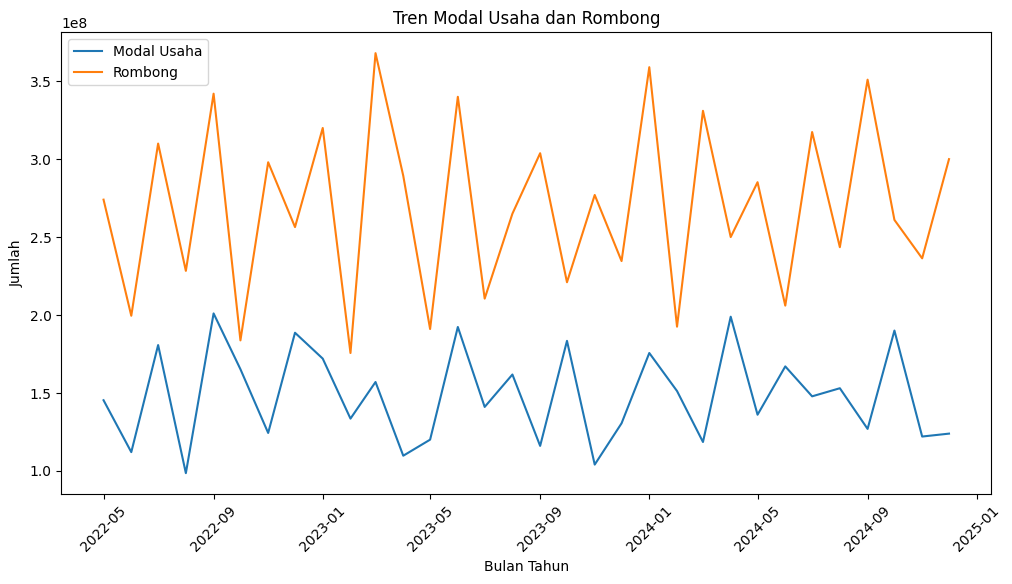

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(df['Bulan Tahun'], df['Modal Usaha'], label='Modal Usaha')
plt.plot(df['Bulan Tahun'], df['Rombong'], label='Rombong')
plt.legend()
plt.title('Tren Modal Usaha dan Rombong')
plt.xlabel('Bulan Tahun')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [114]:
correlation_matrix = df[['Modal Usaha', 'Rombong']].corr()
print(correlation_matrix)

             Modal Usaha   Rombong
Modal Usaha     1.000000  0.168456
Rombong         0.168456  1.000000


##Visualisasi Data Modal Usaha

In [115]:
df = df.drop(columns = 'Rombong') # Hapus baris Modal Usaha karena ingin Menganalisis Modal Usaha terlebih dahulu
df.head() # Menampilkan 5 baris teratas

,Bulan Tahun,Modal Usaha
0,2022-05-01,145300000
1,2022-06-01,112000000
2,2022-07-01,180700000
3,2022-08-01,98500000
4,2022-09-01,201000000


##Split Data Train 90 Test 10

In [116]:
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

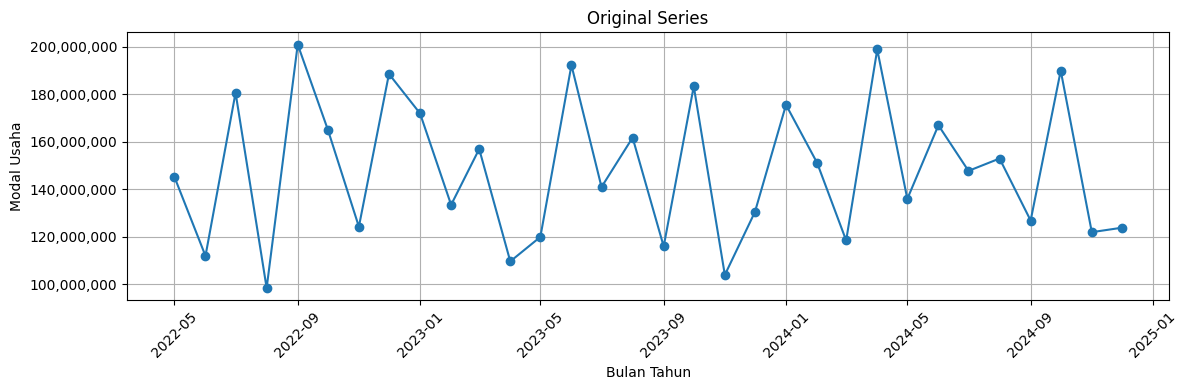

In [117]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 4))

# Plot
plt.plot(df['Bulan Tahun'], df['Modal Usaha'], marker='o')
plt.title('Original Series')
plt.xlabel('Bulan Tahun')
plt.ylabel('Modal Usaha')
plt.grid(True)

# Format angka di sumbu Y tanpa notasi ilmiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Cek kestasioneran secara visual:

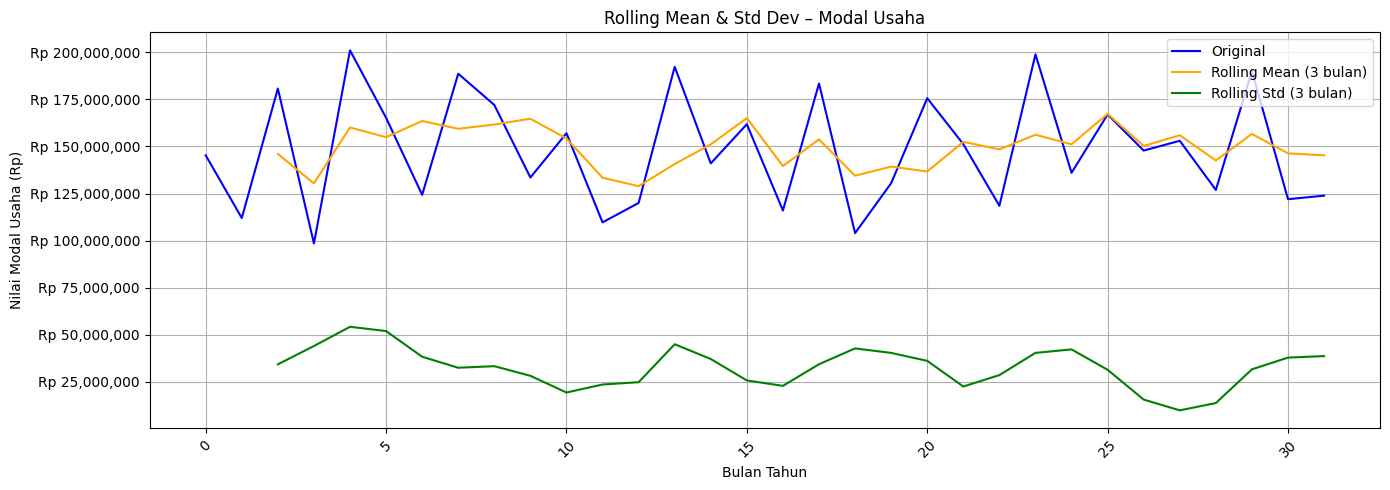

In [118]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Hitung rolling mean dan std dev
rolmean = df['Modal Usaha'].rolling(window=3).mean()
rolstd = df['Modal Usaha'].rolling(window=3).std()

# Plot hasil
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Modal Usaha'], label='Original', color='blue') # Use df.index for x-axis
plt.plot(df.index, rolmean, label='Rolling Mean (3 bulan)', color='orange') # Use df.index for x-axis
plt.plot(df.index, rolstd, label='Rolling Std (3 bulan)', color='green') # Use df.index for x-axis

# Tambahkan label dan format sumbu Y
plt.title('Rolling Mean & Std Dev – Modal Usaha')
plt.xlabel('Bulan Tahun')
plt.ylabel('Nilai Modal Usaha (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Format Y jadi format Rupiah (Rp)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.tight_layout()
plt.show()

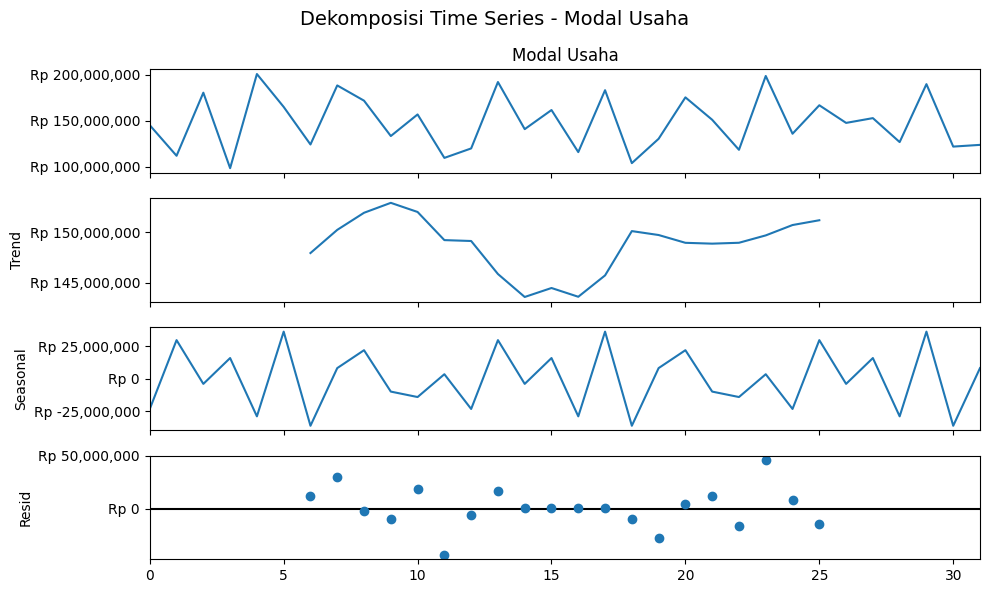

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pastikan kolom tanggal jadi index
# df = df.set_index('Bulan Tahun') # Removed this line

# Decompose (gunakan model 'additive' atau 'multiplicative')
result = seasonal_decompose(df['Modal Usaha'], model='additive', period=12)

# Plot
fig = result.plot()
fig.set_size_inches(10, 6)

# Format sumbu Y jadi Rupiah
for ax in fig.axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.suptitle('Dekomposisi Time Series - Modal Usaha', fontsize=14)
plt.tight_layout()
plt.show()

Visualisasi data menunjukkan pola musiman (seasonal pattern) maka gunakan arima dan sarima (p,d,q)

##Uji ADF (Augmented Dickey-Fuller Test)

In [120]:
result = adfuller(df['Modal Usaha'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Jika p-value > 0.05, lakukan differencing

ADF Statistic: -8.806880
p-value: 0.000000


p-value < 0.05 → berarti data sudah stasioner secara statistik dan ADF Statistic yang sangat negatif

##Plot ACF untuk menentukan nilai q

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

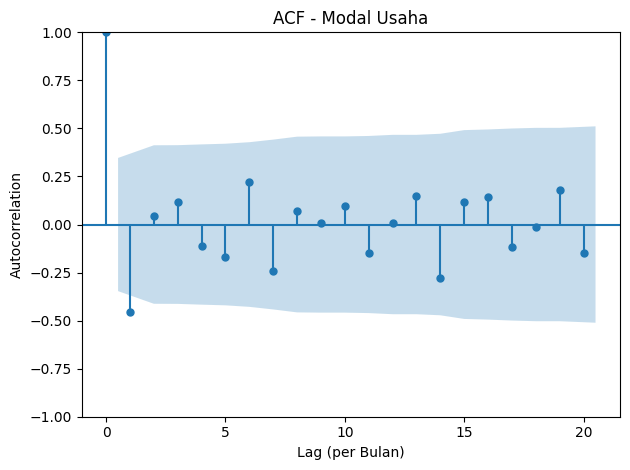

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Modal Usaha'], lags=20)
plt.title('ACF - Modal Usaha')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

Grafik ACF menunjukkan bahwa autokorelasi hanya signifikan pada lag ke-1 dan menurun drastis setelahnya. Ini mengindikasikan bahwa efek memori jangka pendek (moving average) dalam data Modal Usaha relatif rendah, sehingga pemilihan nilai q = 1 untuk model ARIMA cukup tepat.

Pola Terpotong (Cut Off): Untuk menentukan nilai q dari plot ACF, kita mencari pola di mana korelasi "terpotong" atau tiba-tiba jatuh menjadi tidak signifikan.

Ada satu lonjakan (spike) yang sangat signifikan pada Lag 1, yang jelas keluar dari area biru (selang kepercayaan)

Setelah Lag 1, lonjakan pada lag 2, 3, 4, dan 5 langsung jatuh ke dalam area biru, yang berarti korelasinya tidak lagi signifikan

Pola yang terpotong secara jelas setelah Lag 1 ini adalah ciri khas dari model Moving Average orde 1 (MA(1)) atau q 1

###Plot PACF untuk menentukan nilai p

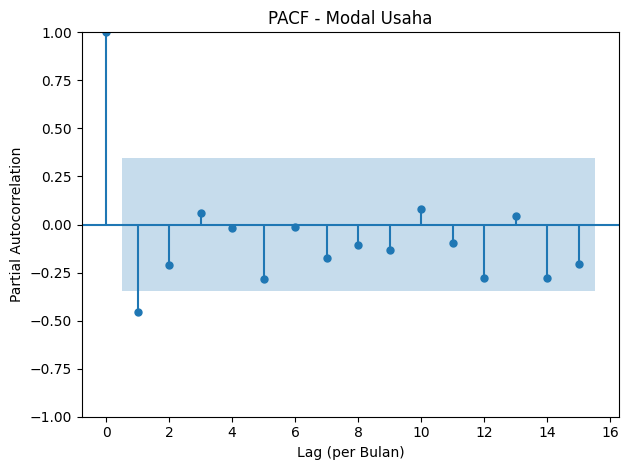

In [123]:
plot_pacf(df['Modal Usaha'], lags=15)
plt.title('PACF - Modal Usaha')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

Untuk mengetahui berapa lag yang memiliki pengaruh langsung (signifikan) terhadap nilai saat ini. Ini digunakan untuk menentukan parameter AR (Auto-Regressive) = p dalam model ARIMA.

Karena hanya lag-1 yang signifikan secara signifikan Berada di luar area biru (confidence interval)

Model ARIMA yang cocok untuk komponen AR-nya adalah p = 1

Hasil grafik PACF menunjukkan autokorelasi parsial yang signifikan hanya pada lag ke-1, dengan nilai yang negatif dan berada di luar batas kepercayaan. Ini menunjukkan bahwa struktur autoregressive dalam data cukup ditangkap oleh AR(1), sehingga model ARIMA yang sesuai adalah dengan parameter p = 1

Sehingga Parameter ARIMA (Dari ACF, PACF, ADF)
p 1 Dari PACF,
d 0 Dari ADF Test,
q 1 Dari ACF

# 2. Forecasting Jenis Rombong

##Visualisasi Data Rombong

In [124]:
import pandas as pd

# Asumsi nama file Excel dan path tetap sama seperti di awal kode
excel_file_path = '/content/Arima_Tiap Bulan.xlsx'

# Baca ulang file Excel ke dalam dataframe df
data = pd.read_excel(excel_file_path)

# Pastikan kolom tanggal bertipe datetime (seperti di awal kode)
data['Bulan Tahun'] = pd.to_datetime(data['Bulan Tahun'])

print("DataFrame data berhasil direset ke kondisi awal:")
print(data.info())
print(data.head())
print(data.isnull().sum()) # Cek kembali missing value
print(data.index.duplicated().sum()) # Cek kembali duplikasi index
print(data.shape) # Cek kembali ukuran data
print(data.columns) # Cek kembali nama kolom

DataFrame data berhasil direset ke kondisi awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bulan Tahun  32 non-null     datetime64[ns]
 1   Modal Usaha  32 non-null     int64         
 2   Rombong      32 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 900.0 bytes
None
  Bulan Tahun  Modal Usaha    Rombong
0  2022-05-01    145300000  274000000
1  2022-06-01    112000000  199500000
2  2022-07-01    180700000  310000000
3  2022-08-01     98500000  228300000
4  2022-09-01    201000000  342000000
Bulan Tahun    0
Modal Usaha    0
Rombong        0
dtype: int64
0
(32, 3)
Index(['Bulan Tahun', 'Modal Usaha', 'Rombong'], dtype='object')


In [125]:
data.head()

,Bulan Tahun,Modal Usaha,Rombong
0,2022-05-01,145300000,274000000
1,2022-06-01,112000000,199500000
2,2022-07-01,180700000,310000000
3,2022-08-01,98500000,228300000
4,2022-09-01,201000000,342000000


In [126]:
data = data.drop(columns = 'Modal Usaha') # Hapus baris Modal Usaha karena ingin Menganalisis Modal Usaha terlebih dahulu
data.head() # Menampilkan 5 baris teratas

,Bulan Tahun,Rombong
0,2022-05-01,274000000
1,2022-06-01,199500000
2,2022-07-01,310000000
3,2022-08-01,228300000
4,2022-09-01,342000000


##Split Data Train 90 Test 10

In [127]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

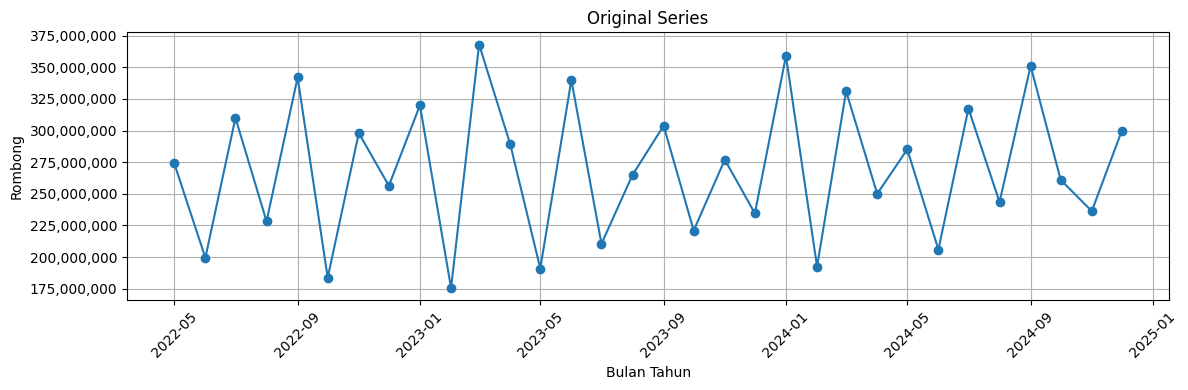

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 4))

# Plot
plt.plot(data['Bulan Tahun'], data['Rombong'], marker='o')
plt.title('Original Series')
plt.xlabel('Bulan Tahun')
plt.ylabel('Rombong')
plt.grid(True)

# Format angka di sumbu Y tanpa notasi ilmiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Cek kestasioneran secara visual:

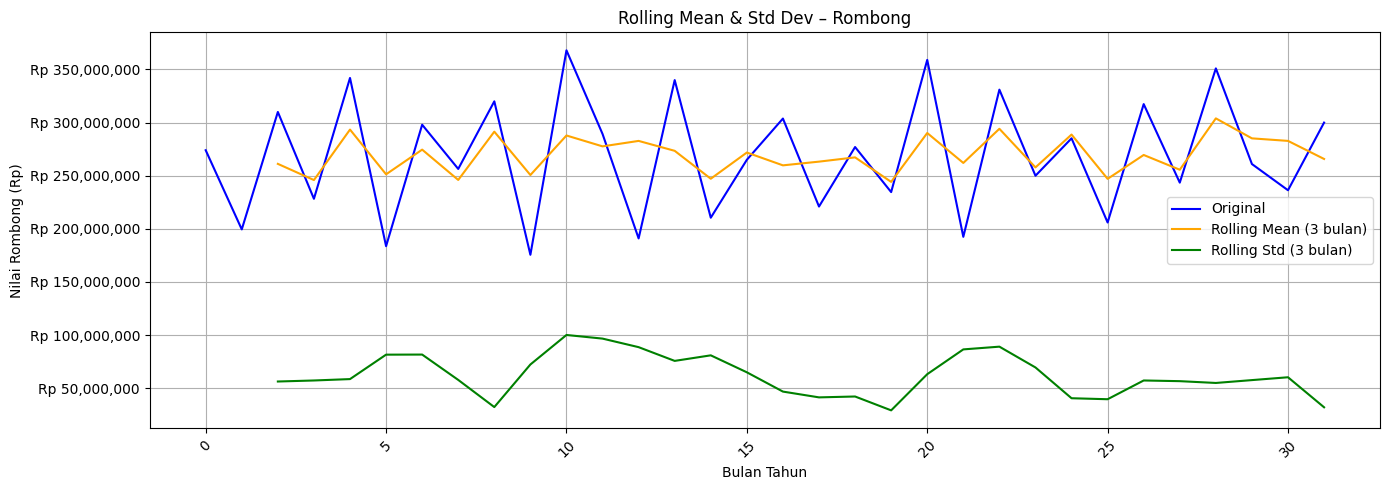

In [129]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Hitung rolling mean dan std dev
rolmean = data['Rombong'].rolling(window=3).mean()
rolstd = data['Rombong'].rolling(window=3).std()

# Plot hasil
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Rombong'], label='Original', color='blue') # Use data.index for x-axis
plt.plot(data.index, rolmean, label='Rolling Mean (3 bulan)', color='orange') # Use data.index for x-axis
plt.plot(data.index, rolstd, label='Rolling Std (3 bulan)', color='green') # Use data.index for x-axis

# Tambahkan label dan format sumbu Y
plt.title('Rolling Mean & Std Dev – Rombong')
plt.xlabel('Bulan Tahun')
plt.ylabel('Nilai Rombong (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Format Y jadi format Rupiah (Rp)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.tight_layout()
plt.show()

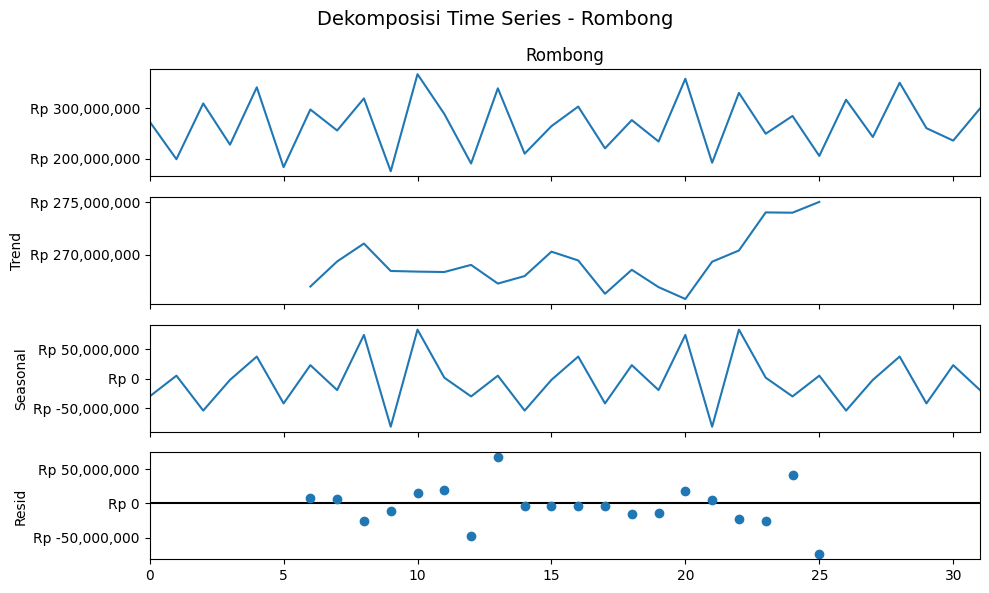

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pastikan kolom tanggal jadi index
# data = data.set_index('Bulan Tahun') # Removed this line

# Decompose (gunakan model 'additive' atau 'multiplicative')
hasil = seasonal_decompose(data['Rombong'], model='additive', period=12)

# Plot
fig = hasil.plot()
fig.set_size_inches(10, 6)

# Format sumbu Y jadi Rupiah
for ax in fig.axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.suptitle('Dekomposisi Time Series - Rombong', fontsize=14)
plt.tight_layout()
plt.show()

Visualisasi data menunjukkan pola musiman (seasonal pattern) maka gunakan arima dan sarima (p,d,q)

##Uji ADF (Augmented Dickey-Fuller Test)

In [131]:
from statsmodels.tsa.stattools import adfuller

In [132]:
hasil = adfuller(data['Rombong'].dropna())
print('ADF Statistic: %f' % hasil[0])
print('p-value: %f' % hasil[1])
# Jika p-value > 0.05, lakukan differencing

ADF Statistic: -6.898188
p-value: 0.000000


p-value < 0.05 → berarti data sudah stasioner secara p-value dan ADF Statistic yang sangat negatif

##Plot ACF nilai q

In [133]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

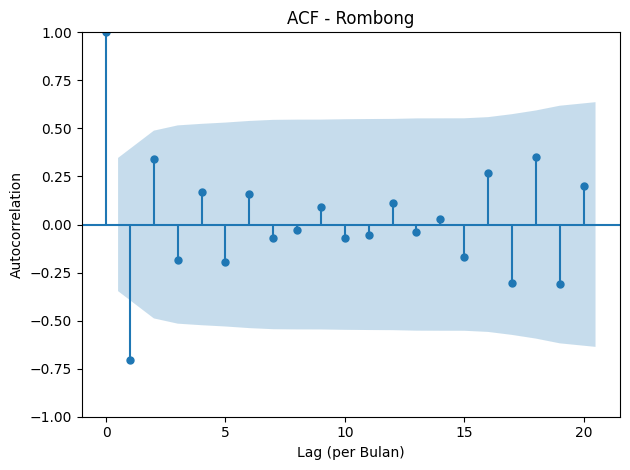

In [134]:
plot_acf(data['Rombong'], lags=20)
plt.title('ACF - Rombong')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

Grafik ACF menunjukkan bahwa autokorelasi hanya signifikan pada lag ke-1 dan menurun drastis setelahnya. Ini mengindikasikan bahwa efek memori jangka pendek (moving average) dalam data Modal Usaha relatif rendah, sehingga pemilihan nilai q = 1 untuk model ARIMA cukup tepat.

Pola Terpotong (Cut Off): Untuk menentukan nilai q dari plot ACF, kita mencari pola di mana korelasi "terpotong" atau tiba-tiba jatuh menjadi tidak signifikan.

Ada satu lonjakan (spike) yang sangat signifikan pada Lag 1, yang jelas keluar dari area biru (selang kepercayaan)

Setelah Lag 1 dan Lag 2, lonjakan pada lag 3, 4, dan 5 langsung jatuh ke dalam area biru, yang berarti korelasinya tidak lagi signifikan

Pola yang terpotong secara jelas setelah Lag 2 ini adalah ciri khas dari model Moving Average orde 2 (MA(2)) atau q 2

###Plot PACF untuk tentukan nilai p

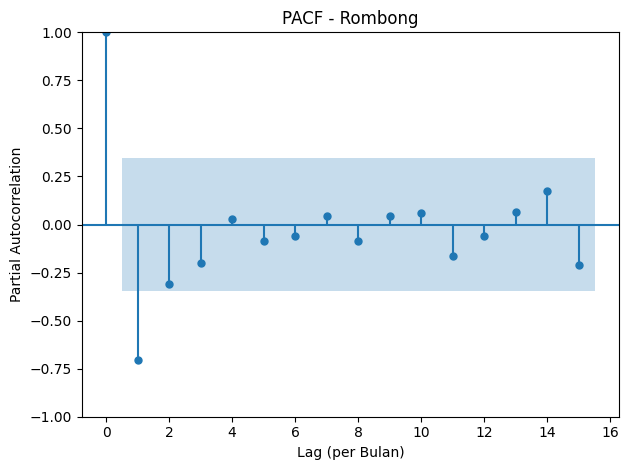

In [135]:
plot_pacf(data['Rombong'], lags=15)
plt.title('PACF - Rombong')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

Untuk mengetahui berapa lag yang memiliki pengaruh langsung (signifikan) terhadap nilai saat ini. Ini digunakan untuk menentukan parameter AR (Auto-Regressive) = p dalam model ARIMA.

jika batang PACF signifikan hanya di lag ke-1 dan ke-2

maka nilai p = 2

#a. Bangun Model ARIMA (Rombong)

Sehingga Parameter ARIMA (Dari ACF, PACF, ADF)
p 2 Dari PACF,
d 0 Dari ADF Test,
q 2 Dari ACF

In [136]:
from statsmodels.tsa.arima.model import ARIMA

model_arima_rombong = ARIMA(data['Rombong'], order=(2, 0, 2))
hasil_arima_rombong = model_arima_rombong.fit()
print(hasil_arima_rombong.summary())

                               SARIMAX Results                                
Dep. Variable:                Rombong   No. Observations:                   32
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -602.023
Date:                Tue, 15 Jul 2025   AIC                           1216.046
Time:                        05:59:39   BIC                           1224.840
Sample:                             0   HQIC                          1218.961
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.694e+08   1.37e+06    196.422      0.000    2.67e+08    2.72e+08
ar.L1          0.1489      1.212      0.123      0.902      -2.226       2.524
ar.L2          0.3146      0.323      0.975      0.3

Kesimpulan Awal Model ARIMA(2,0,2)
Model valid secara statistik (residual normal, tidak ada autokorelasi),
AR(2) tidak terlalu signifikan, tapi MA(2) kuat,
AIC masih bisa dicoba diturunkan dengan eksplorasi model alternatif

##Forecast 12 Bulan ke depan dan Visualisasi model 202

In [137]:
data.head()

,Bulan Tahun,Rombong
0,2022-05-01,274000000
1,2022-06-01,199500000
2,2022-07-01,310000000
3,2022-08-01,228300000
4,2022-09-01,342000000


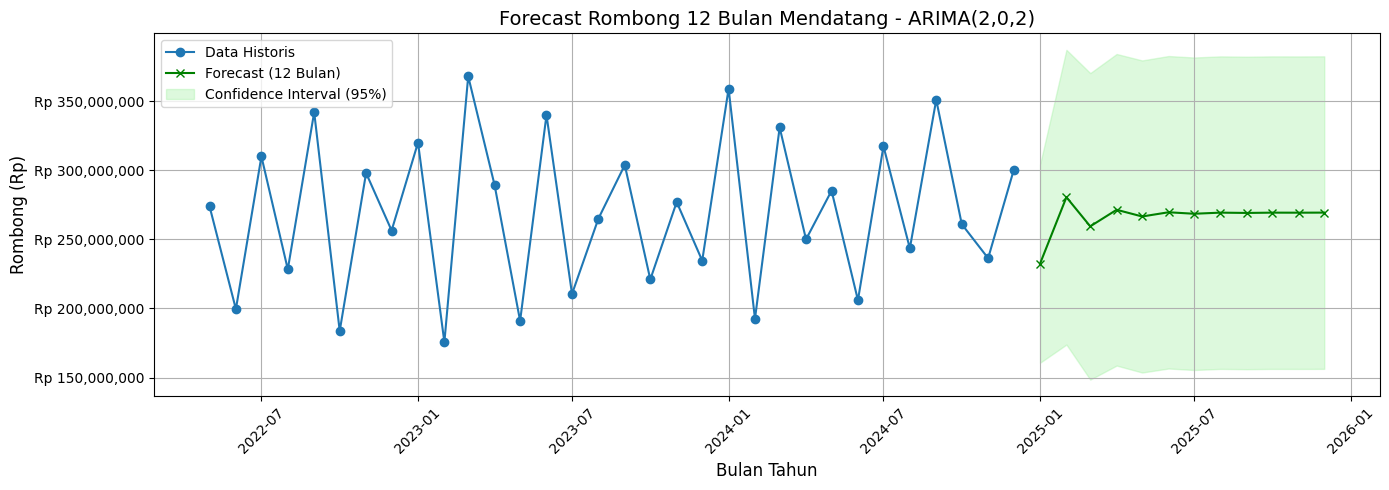

In [138]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Salin data untuk plotting, lalu ubah index hanya pada salinan
data_plot = data.copy()
data_plot['Bulan Tahun'] = pd.to_datetime(data_plot['Bulan Tahun'])  # pastikan datetime
data_plot.set_index('Bulan Tahun', inplace=True)

# Buat forecast ARIMA sebelumnya (pastikan model sudah fit)
# Misalnya: hasil_arima = ARIMA(data_plot['Rombong'], order=(1,0,1)).fit()
forecast = hasil_arima_rombong.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Buat index 12 bulan ke depan
future_index = pd.date_range(start=data_plot.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# Salin forecast hasil ke DataFrame baru agar aman
forecast_mean = forecast.predicted_mean.copy()
forecast_mean.index = future_index
forecast_ci.index = future_index

# Visualisasi
plt.figure(figsize=(14, 5))
plt.plot(data_plot.index, data_plot['Rombong'], label='Data Historis', marker='o')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast (12 Bulan)', color='green', marker='x')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='lightgreen', alpha=0.3, label='Confidence Interval (95%)')

# Format Y ke Rupiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

# Label dan legend
plt.title('Forecast Rombong 12 Bulan Mendatang - ARIMA(2,0,2)', fontsize=14)
plt.xlabel('Bulan Tahun', fontsize=12)
plt.ylabel('Rombong (Rp)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [139]:
# Buat DataFrame hasil forecast
# Create a proper date index for the forecast
last_date = data['Bulan Tahun'].iloc[-1] # Get the last date from the original data
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

forecast_table = pd.DataFrame({
    'Bulan Tahun': future_index.strftime('%Y-%m'), # Use the created date index
    'Prediksi Rombong (Rp)': forecast.predicted_mean.values.astype(int)
})

# Format kolom prediksi ke dalam bentuk Rupiah
forecast_table['Prediksi Rombong (Rp)'] = forecast_table['Prediksi Rombong (Rp)'].apply(
    lambda x: f"Rp {x:,.0f}".replace(',', '.') # Changed comma to dot for thousands separator
)

# Tampilkan sebagai tabel rapi di output
print(forecast_table.to_string(index=False))

# Simpan ke Excel
forecast_table.to_excel("forecast_rombong_2025.xlsx", index=False)

Bulan Tahun Prediksi Rombong (Rp)
    2025-01        Rp 232.420.690
    2025-02        Rp 280.508.023
    2025-03        Rp 259.418.042
    2025-04        Rp 271.405.765
    2025-05        Rp 266.555.849
    2025-06        Rp 269.604.958
    2025-07        Rp 268.533.182
    2025-08        Rp 269.332.819
    2025-09        Rp 269.114.699
    2025-10        Rp 269.333.778
    2025-11        Rp 269.297.776
    2025-12        Rp 269.361.334


##Perbandingan Model Alternatif dan Bandingkan AIC

In [140]:
from statsmodels.tsa.arima.model import ARIMA

# Model 1: ARIMA(1,0,1)
model_101_rombong = ARIMA(data['Rombong'], order=(1, 0, 1))
result_101_rombong = model_101_rombong.fit()

# Model 2: ARIMA(2,0,1)
model_201_rombong = ARIMA(data['Rombong'], order=(2, 0, 1))
result_201_rombong = model_201_rombong.fit()

# Model 3: ARIMA(1,0,2)
model_102_rombong = ARIMA(data['Rombong'], order=(1, 0, 2))
result_102_rombong = model_102_rombong.fit()

# Model 4: ARIMA(2,0,2)
model_202_rombong = ARIMA(data['Rombong'], order=(2, 0, 2))
result_202_rombong = model_202_rombong.fit()

# Cetak AIC masing-masing
print(f"AIC ARIMA(1,0,1): {result_101_rombong.aic:.2f}")
print(f"AIC ARIMA(2,0,1): {result_201_rombong.aic:.2f}")
print(f"AIC ARIMA(1,0,2): {result_102_rombong.aic:.2f}")
print(f"AIC ARIMA(2,0,2): {result_202_rombong.aic:.2f}")

AIC ARIMA(1,0,1): 1213.16
AIC ARIMA(2,0,1): 1214.14
AIC ARIMA(1,0,2): 1215.10
AIC ARIMA(2,0,2): 1216.05


AIC Terkecil tetap pada model 1,0,1. Sehingga Model dengan AIC paling rendah atau AIC ARIMA (1,0,1) dianggap paling optimal dibanding model lainnya yang diuji pada data yang sama.

##Forecast 12 Bulan untuk Tiap Model

In [141]:
# Forecast untuk ARIMA(1,0,1)
forecast_101_rombong = result_101_rombong.get_forecast(steps=12)
ci_101_rombong = forecast_101_rombong.conf_int()

# Forecast untuk ARIMA(2,0,1)
forecast_201_rombong = result_201_rombong.get_forecast(steps=12)
ci_201_rombong = forecast_201_rombong.conf_int()

# Forecast untuk ARIMA(1,0,2)
forecast_102_rombong = result_102_rombong.get_forecast(steps=12)
ci_102_rombong = forecast_102_rombong.conf_int()

# Forecast untuk ARIMA(2,0,2)
forecast_202_rombong = result_202_rombong.get_forecast(steps=12)
ci_202_rombong = forecast_202_rombong.conf_int()

##Visualisasikan Perbandingan Model

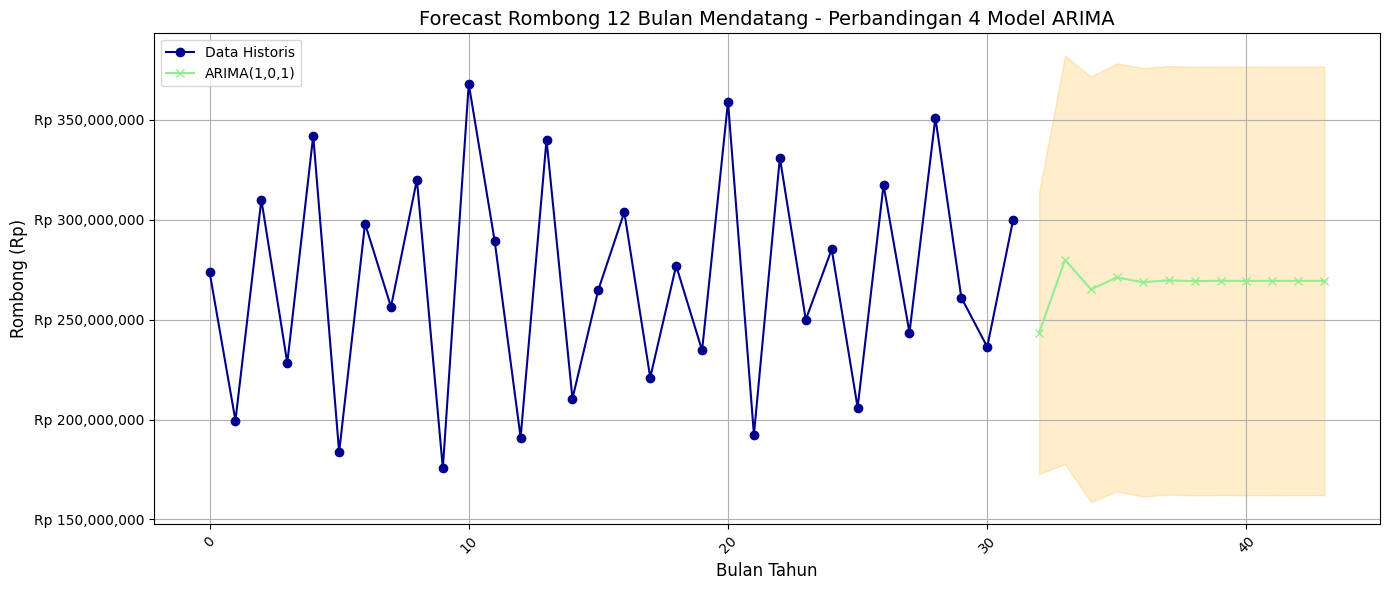

In [154]:
plt.figure(figsize=(14, 6))

# Plot data historis (using 'data' DataFrame)
plt.plot(data.index, data['Rombong'], label='Data Historis', color='darkblue', marker='o')

# Forecast ARIMA(1,0,1)
plt.plot(forecast_101_rombong.predicted_mean.index, forecast_101_rombong.predicted_mean.values,
         label='ARIMA(1,0,1)', color='lightgreen', marker='x')
plt.fill_between(ci_101_rombong.index, ci_101_rombong.iloc[:, 0], ci_101_rombong.iloc[:, 1], # Use ci_101_rombong
                 color='orange', alpha=0.2)

# Format sumbu Y ke dalam format Rupiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

# Label dan tampilan
plt.title('Forecast Rombong 12 Bulan Mendatang - Perbandingan 4 Model ARIMA', fontsize=14)
plt.xlabel('Bulan Tahun', fontsize=12)
plt.ylabel('Rombong (Rp)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
import pandas as pd

# Buat salinan data untuk digunakan sebagai index datetime (tanpa mengubah data asli)
data_temp = data.copy()
data_temp['Bulan Tahun'] = pd.to_datetime(data_temp['Bulan Tahun'])
data_temp = data_temp.set_index('Bulan Tahun')

# Ambil tanggal terakhir
last_date = data_temp.index[-1]

# Buat index waktu 12 bulan ke depan
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Buat DataFrame hasil forecast dari 4 model
forecast_data = pd.DataFrame({
    'Bulan Tahun': future_index.strftime('%Y-%m'),
    'ARIMA(1,0,1)': forecast_101_rombong.predicted_mean.values,
    'ARIMA(2,0,1)': forecast_201_rombong.predicted_mean.values,
    'ARIMA(1,0,2)': forecast_102_rombong.predicted_mean.values,
    'ARIMA(2,0,2)': forecast_202_rombong.predicted_mean.values
})

# Format nilai forecast ke dalam bentuk Rupiah
def format_rupiah(x):
    return f"Rp {x:,.0f}".replace(",", ".")

formatted_forecast_data = forecast_data.copy()
for col in forecast_data.columns[1:]:
    formatted_forecast_data[col] = forecast_data[col].apply(format_rupiah)

# Tampilkan tabel hasil forecast
print(formatted_forecast_data.to_string(index=False))


Bulan Tahun   ARIMA(1,0,1)   ARIMA(2,0,1)   ARIMA(1,0,2)   ARIMA(2,0,2)
    2025-01 Rp 243.322.801 Rp 227.349.762 Rp 234.653.801 Rp 232.420.691
    2025-02 Rp 279.895.594 Rp 282.515.853 Rp 282.163.370 Rp 280.508.023
    2025-03 Rp 265.166.125 Rp 257.285.178 Rp 261.444.731 Rp 259.418.042
    2025-04 Rp 271.098.329 Rp 274.236.300 Rp 274.345.591 Rp 271.405.765
    2025-05 Rp 268.709.170 Rp 265.766.463 Rp 266.312.622 Rp 266.555.850
    2025-06 Rp 269.671.389 Rp 271.070.130 Rp 271.314.505 Rp 269.604.958
    2025-07 Rp 269.283.861 Rp 268.278.089 Rp 268.199.986 Rp 268.533.182
    2025-08 Rp 269.439.936 Rp 269.956.317 Rp 270.139.301 Rp 269.332.820
    2025-09 Rp 269.377.078 Rp 269.045.222 Rp 268.931.749 Rp 269.114.700
    2025-10 Rp 269.402.393 Rp 269.579.920 Rp 269.683.655 Rp 269.333.779
    2025-11 Rp 269.392.198 Rp 269.284.327 Rp 269.215.466 Rp 269.297.776
    2025-12 Rp 269.396.304 Rp 269.455.390 Rp 269.506.993 Rp 269.361.335


In [144]:
# Simpan ke file Excel
output_path = 'forecast_12_tiap-model(Rombong).xlsx'
formatted_forecast_data.to_excel(output_path, index=False)
print(f"File berhasil disimpan ke: {output_path}")

File berhasil disimpan ke: forecast_12_tiap-model(Rombong).xlsx


##Evaluasi MAE, RMSE, dan MAPE

In [145]:
train = data.iloc[:-12]
test = data.iloc[-12:]

Hanya data Training

In [146]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model ke data training
model = ARIMA(train['Rombong'], order=(1,0,1))
hasil = model.fit()

# Forecast 12 bulan ke depan (dari posisi test set)
forecast = hasil.get_forecast(steps=12)
y_pred = forecast.predicted_mean

# Reindex prediksi ke tanggal test set
y_pred.index = test.index

In [148]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test['Rombong']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print(f"Nilai Rata-rata kesalahan absolut dalam prediksi (MAE)                                : {mae:,.0f}".replace(",", "."))
print(f"Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (RMSE)            : {rmse:,.0f}".replace(",", "."))
print(f"Presentase Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (MAPE) : {mape:.2f}%")


Nilai Rata-rata kesalahan absolut dalam prediksi (MAE)                                : 41.286.313
Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (RMSE)            : 47.854.031
Presentase Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (MAPE) : 14.95%
